# Exploring FNA Image Dataset to Identify and Predict Breast Cancer
##### Daniella Raz
##### October 14, 2018

## Table of contents
1. [Purpose](#Purpose)
2. [About the Data](#About)
3. [Data Exploration and Data Preparation](#Data)
    1. [Loading and Cleaning Data](#Loading)
    2. [Preliminary Visualizations](#Preliminary)
    2. [Correlations](#Correlations)
    3. [Examining Benign Versus Malignant Masses](#Examining)
    4. [Distributions](#Distributions)
    5. [Outliers, Addt'l Distribution Plots, and Dispersion](#Outliers)
    6. [Standardizing Data](#Standardizing)
    7. [Data Exploration Summary](#Summary)
4. [Predictive Modeling](#Predictive)
    1. [Dimension Reduction, PCA](#Dimension)
    2. [Logistic Regression](#Logistic)

## I. Purpose <a name="Purpose"></a>
> In this notebook, I visualize and analyze the data retrieved from breast masses removed during biopsy. My goal is to build a model that can identify malignant vs benign tumors based on the breast mass features included in the dataset. As I lack training in oncology and tumor biology, my analytic approach is entirely data-driven, with a narrow aim of identifying variables that maximize classification according to the expert diagnostic decisions.

## II. About the Data <a name="About"></a>
> Dataset can be found here courtesy of the University of Wisconsin: 

> https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

> This dataset contains variables that represent features extracted from digitized images of biopsy (fine needle aspirate, FNA) of a breast mass, and diagnostic decision on malignancy of the mass - malignant vs benign. "All feature values are recoded with four significant digits." The following are the features that have been extracted from each mass image:

> - radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness (perimeter^2 / area - 1.0) 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour) 
- symmetry 
- fractal dimension ("coastline approximation" - 1) 

## III. Data Exploration and Data Cleaning <a name="Data"></a>

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import re

%matplotlib inline

#### **a. Loading and Cleaning Data:** <a name="Loading"></a>

In [338]:
# load & view data, dropping id
bc_data = pd.read_csv('data.csv')
bc_data = bc_data.drop(['id', 'Unnamed: 32'], axis = 1)
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [339]:
# number of rows, columns
bc_data.shape

(569, 31)

In [340]:
# Checking datatypes, diagnosis will need to be converted to 1s and 0s
bc_data.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [341]:
# converting diagnosis to numeric
bc_data['diagnosis'] = np.where(bc_data['diagnosis']=='M', 1, 0)

In [342]:
# sanity check
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [343]:
# sanity check, are there both 1s and 0s?
bc_data['diagnosis'].unique()

array([1, 0])

In [344]:
# checking presence of any null values
bc_data.isnull().values.any()

False

#### **b. Preliminary Visualizations:** <a name="Preliminary"></a>

> Intuitively, it makes sense that the size of a mass would have some correlation with diagnosis. This section examines some preliminary scatterplots comparing radius_mean (a reflection of tumor size) with other characteristics to identify some initial trends that might prove relevant once examined more rigorously.

> Figure 1.1 shows that generally malignant tumors seem to have a larger radius than do benign ones. However, tumor texture varies widely within benign and malignant tumors. Such between-group and within-group variation suggests that texture is a noisy variable and likely an unsuitable classifier.

> Figure 1.2 shows that generally benign masses are concentrated in the lower left corner - meaning benign masses have a smaller mean radius and smaller value for mean compactness. In the extreme high values for both radius_mean, as shown in figure 1.1, and for compactness_mean the majority of masses are malignant. Initially, it seems that looking at at compactness_mean could provide some insight into the diagnosis of the mass. The combination of both a high value for compactness_mean and radius_mean seems to point to a malignant tumor. 

> Figure 1.3 shows that the combination of both a large radius and a high value for concavity_mean points to a malignant tumor. The benign masses primarily exhibit a concavity_mean value of less than 0.1. Concavity_mean might also be useful to determine the diagnosis.

In [349]:
# ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
bc_data['Diagnosis'] = bc_data['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

Text(0.5,1,'Figure 1.1')

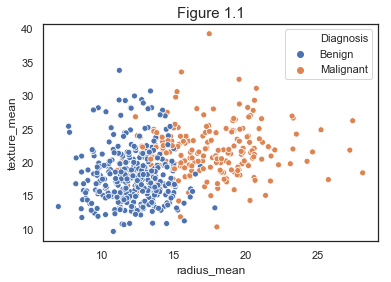

In [350]:
# exploring how radius_mean, texture_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="texture_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.1", fontsize= 15)

Text(0.5,1,'Figure 1.2')

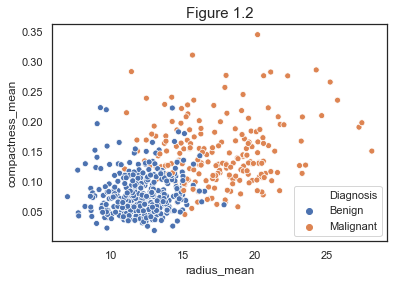

In [351]:
#exploring how radius_mean, compactness_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="compactness_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.2", fontsize = 15)

Text(0.5,1,'Figure 1.3')

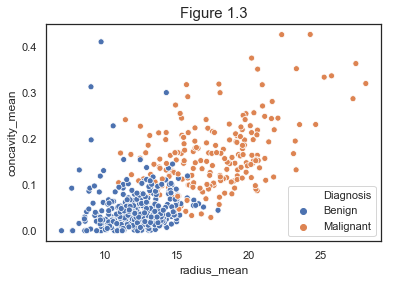

In [352]:
#exploring how radius_mean, concavity_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="concavity_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.3", fontsize = 15)

#### **c. Correlations:** <a name="Correlations"></a>

> The correlation plot shows that radius, area, and perimeter for all 3 categories found in the data (worst, se, and mean categories) have a very high correlation. Mathematically, this correlation is straightforward given that area, perimeter, and radius are highly related measurements. Retaining all three measurements in later predictive modeling would be redundant. Thus, of the three measurements I only retain area_mean, area_worst, and area_se. 

> Other highly correlated (≥ 0.9) features are concave_points_mean and concavity_mean (0.92), texture_worst and texture_mean (0.91), area_worst and area_mean (0.96), as well as concave_points_worst and concave_points_mean (0.91). I will retain concavity_mean, area_mean, and concave_points_mean. However, I drop both texture_worst and texture_mean, because in the preliminary visualizations tumor texture showed great variation within both malignant and benign tumors, suggesting it to be an unsuitable classifier. Given that texture_se is not highly correlated with texture_mean and thus seems to represent a distinct feature of tumor masses I keep this feature. 

Text(0.5,1,'Figure 2.1 Correlation Heatmap')

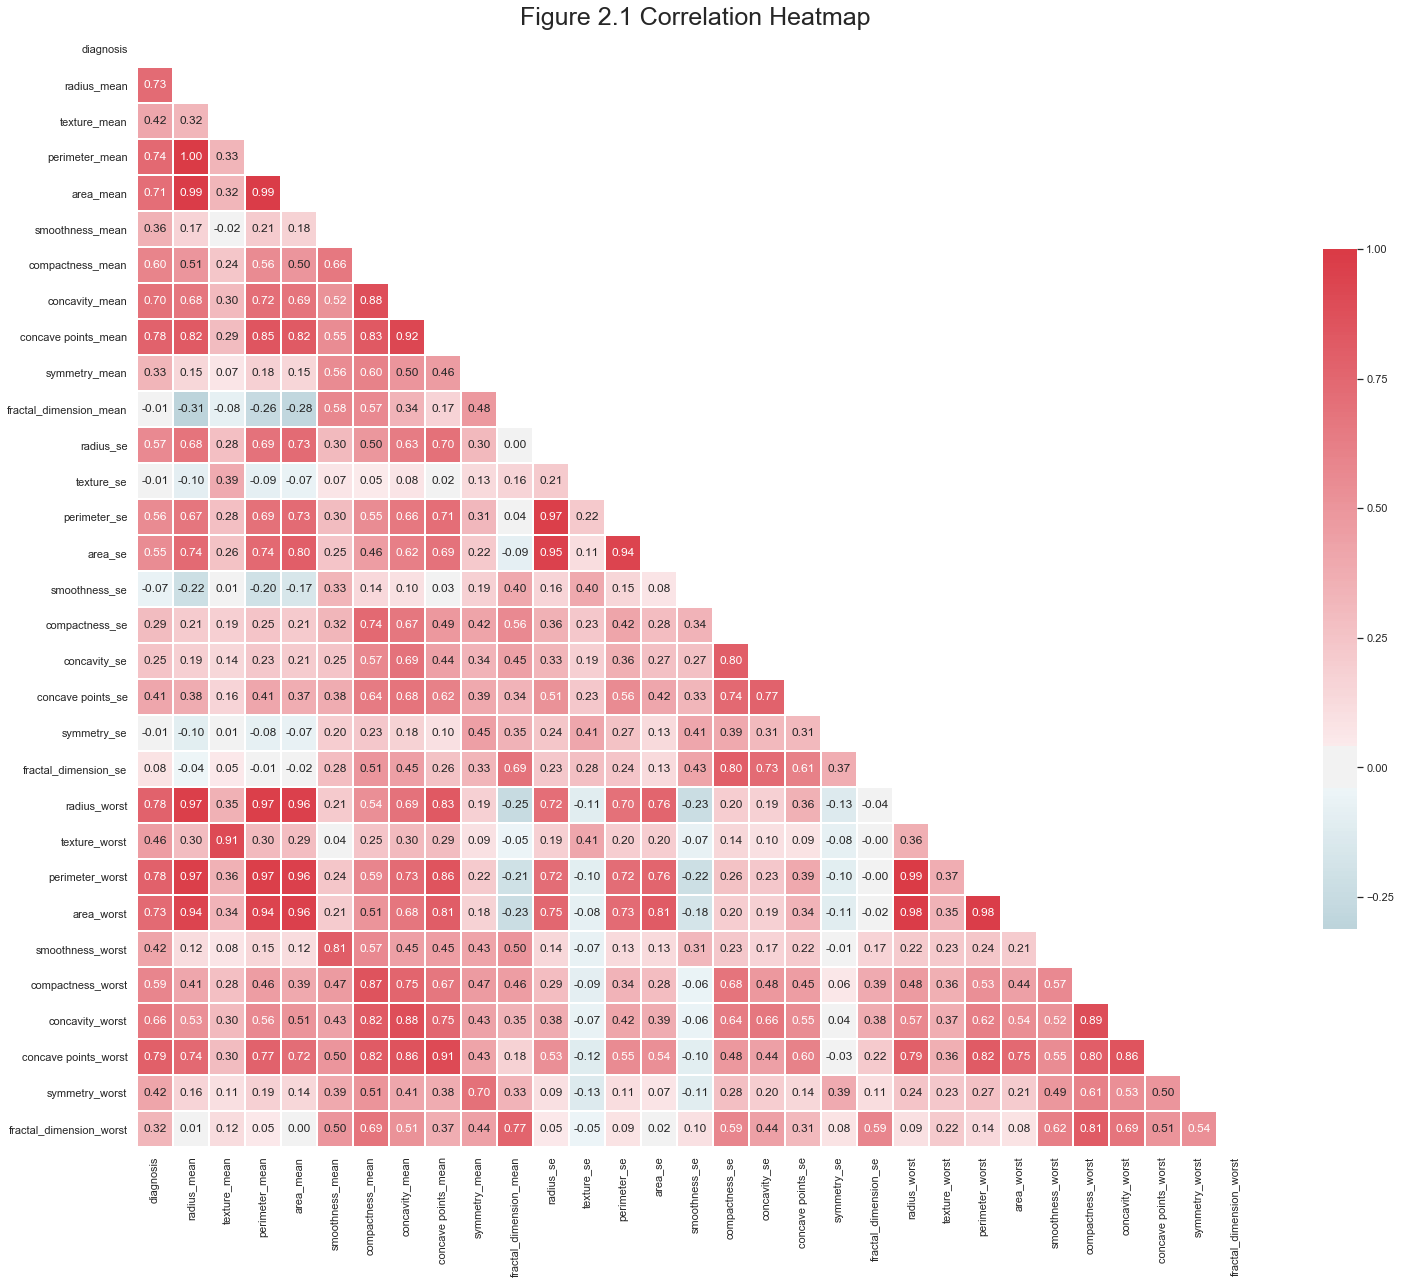

In [353]:
# source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set(style="white")
bc_data_corr = bc_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(bc_data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(bc_data_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f')

ax.set_title("Figure 2.1 Correlation Heatmap", fontsize= 25)

In [357]:
all_features = list(bc_data)
all_features = [x for x in all_features if x != 'Diagnosis']

In [358]:
# dropping perimeter and radius features, keeping area features, due to high correlation
regex = re.compile(r'perimeter|radius|texture_mean|texture_worst|area_worst|concave_points_worst|concave points_mean')
features = [x for x in all_features if not regex.search(x)]

In [359]:
# sanity check
features

['diagnosis',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'texture_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [360]:
# removing the selected highly correlated features from bc_data
bc_data_no_corr = bc_data[features]

In [361]:
bc_data_no_corr.head(5)

,diagnosis,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1001.0,0.11840,0.27760,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,...,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,1326.0,0.08474,0.07864,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,...,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,1203.0,0.10960,0.15990,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,...,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,386.1,0.14250,0.28390,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,...,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,1297.0,0.10030,0.13280,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,...,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### **d. Examining Benign versus Malignant Masses:** <a name="Examining"></a>

> <font color="magenta">NEED TO FINISH INTERPRETATION</font>

> At first glance, here are some notable differences between malignant and benign masses. 
> - The mean for every variable measuring mass size (area, radius, perimeter) is larger for malignant masses than for benign ones.
>>> - ***Comparing standard deviations, ***
>>> - ***Compare 25% and 50% and 75% ***


In [363]:
# describes data for malignant breast masses 
malignant_data = bc_data_no_corr.loc[bc_data_no_corr['diagnosis'] == 1]
malignant_data.describe()

,diagnosis,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1.0,978.376415,0.102898,0.145188,0.160775,0.192909,0.062680,1.210915,72.672406,0.006780,...,0.041824,0.015060,0.020472,0.004062,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
std,0.0,367.937978,0.012608,0.053987,0.075019,0.027638,0.007573,0.483178,61.355268,0.002890,...,0.021603,0.005517,0.010065,0.002041,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553
min,1.0,361.600000,0.073710,0.046050,0.023980,0.130800,0.049960,0.362100,13.990000,0.002667,...,0.011010,0.005174,0.007882,0.001087,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040
25%,1.0,705.300000,0.094010,0.109600,0.109525,0.174050,0.056598,0.892825,35.762500,0.005085,...,0.026998,0.011415,0.014615,0.002688,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302
50%,1.0,932.000000,0.102200,0.132350,0.151350,0.189900,0.061575,1.102500,58.455000,0.006209,...,0.037125,0.014205,0.017700,0.003739,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600
75%,1.0,1203.750000,0.110925,0.172400,0.203050,0.209850,0.067075,1.429250,94.000000,0.007971,...,0.050443,0.017497,0.022132,0.004892,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625
max,1.0,2501.000000,0.144700,0.345400,0.426800,0.304000,0.097440,3.568000,542.200000,0.031130,...,0.143800,0.040900,0.078950,0.012840,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500


In [364]:
# describes data for benign breast masses
benign_data = bc_data_no_corr.loc[bc_data_no_corr['diagnosis'] == 0]
benign_data.describe()

,diagnosis,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,...,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,357.0,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.00000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.0,462.790196,0.092478,0.080085,0.046058,0.174186,0.062867,1.22038,21.135148,0.007196,...,0.025997,0.009858,0.020584,0.003636,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
std,0.0,134.287118,0.013446,0.033750,0.043442,0.024807,0.006747,0.58918,8.843472,0.003061,...,0.032918,0.005709,0.006999,0.002938,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
min,0.0,143.500000,0.052630,0.019380,0.000000,0.106000,0.051850,0.36020,6.802000,0.001713,...,0.000000,0.000000,0.009539,0.000895,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210
25%,0.0,378.200000,0.083060,0.055620,0.020310,0.158000,0.058530,0.79590,15.260000,0.005212,...,0.010990,0.006433,0.015600,0.002074,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090
50%,0.0,458.400000,0.090760,0.075290,0.037090,0.171400,0.061540,1.10800,19.630000,0.006530,...,0.018400,0.009061,0.019090,0.002808,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120
75%,0.0,551.100000,0.100700,0.097550,0.059990,0.189000,0.065760,1.49200,25.030000,0.008534,...,0.030560,0.011870,0.024060,0.004174,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410
max,0.0,992.100000,0.163400,0.223900,0.410800,0.274300,0.095750,4.88500,77.110000,0.021770,...,0.396000,0.052790,0.061460,0.029840,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600


#### **e. Distributions:** <a name="Distributions"></a>

> <font color="magenta">NEED TO FINISH INTERPRETATION</font>

> Most features seem normally distributed for both benign and malignant masses. However

>Here are a few observations based on the distribution plots:
- radius, texture, perimeter, area, concavity (average & average points) appear to be mostly distinct based on the diagnosis 
- smoothness, compactness, symmetry, fractal appear to have significant overlap regardless of diagnosis 

In [382]:
def multiplePlots(feature_name, n):
    # plot set up, sizing, title, padding
    fig, axs = plt.subplots(1, 2, sharey = False)
    plt.tight_layout(w_pad=6)
    fig.subplots_adjust(top=0.85)
    fig.suptitle('Figure 2.'+str(n)+': Distribution of ' + feature_name + ' variable', fontsize=15)
    
    # histogram for benign
    axs[0].set_title('Histogram for Benign vs. Malignant')
    sns.distplot(benign_data[feature], ax=axs[0], label="benign")
    # histogram for malignant
    sns.distplot(malignant_data[feature], ax=axs[0], label="malignant")
    axs[0].legend()
    
    # QQ plot for benign
    axs[1].set_title('QQ Plot for Benign vs. Malignant')
    qntls, xr = stats.probplot(benign_data[feature], fit=False)
    sns.regplot(xr,qntls, ax=axs[1], label="benign")
    # QQ plot for malignant
    qntls2, xr2 = stats.probplot(malignant_data[feature], fit=False)
    sns.regplot(xr2,qntls2, ax=axs[1], label="malignant")
    axs[1].legend()

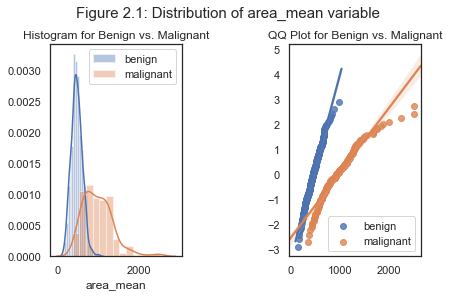

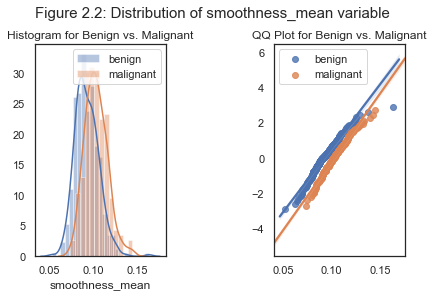

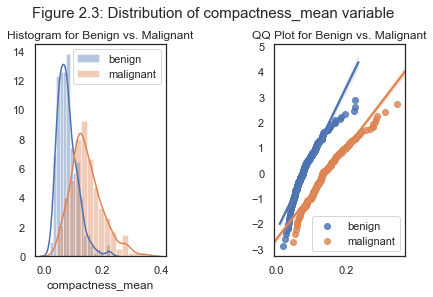

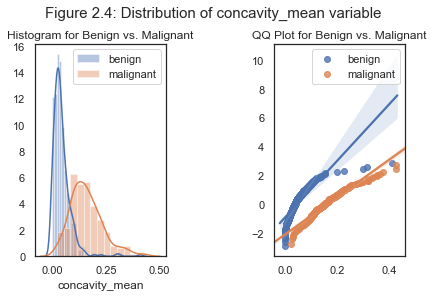

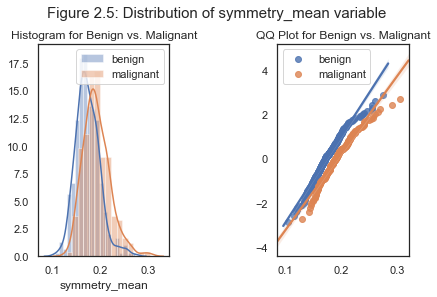

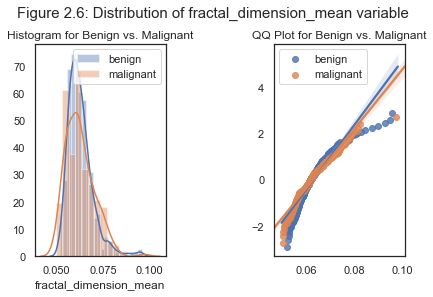

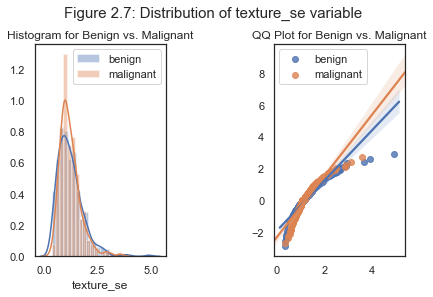

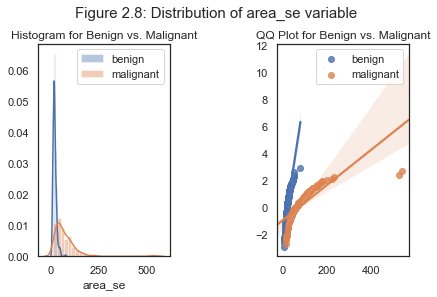

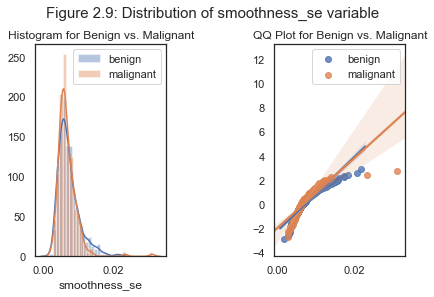

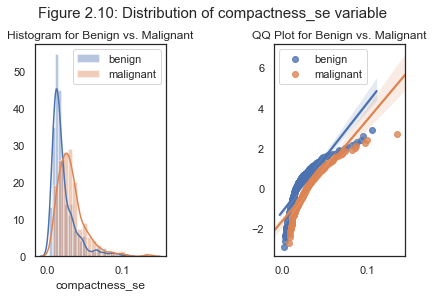

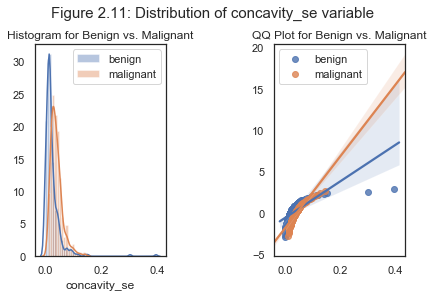

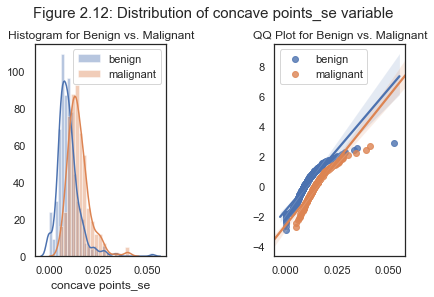

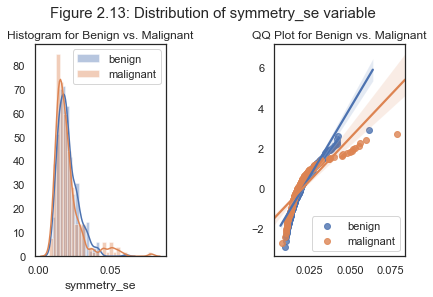

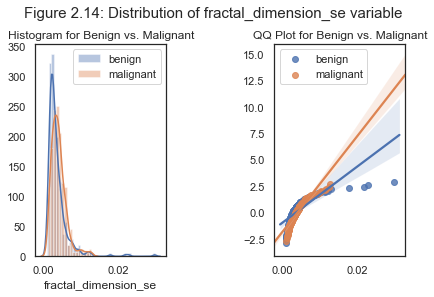

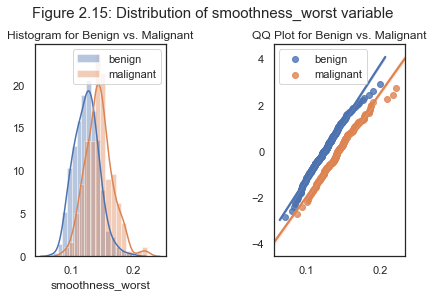

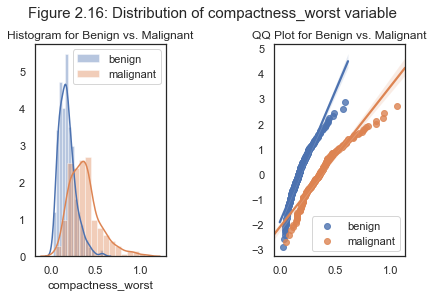

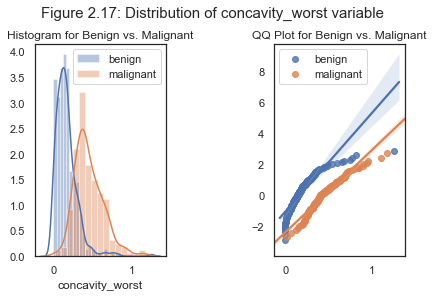

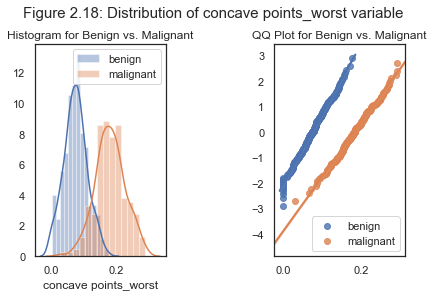

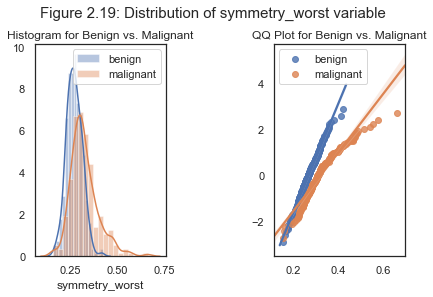

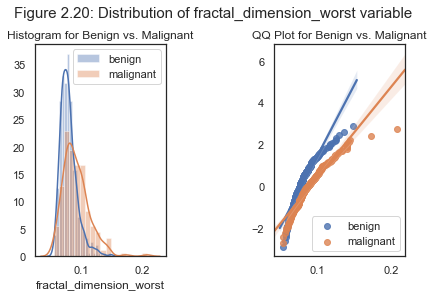

In [383]:
# plotting distributions plots (histogram and qqplot) of all variables for both benign and malignant
n = 1
for feature in features[1:]:
    multiplePlots(feature, n)
    n += 1

#### **f. Outliers, Addt'l Distribution Plots, and Dispersion:** <a name="Outliers"></a>

> <font color="magenta">NEED TO FINISH INTERPRETATION</font>

> 

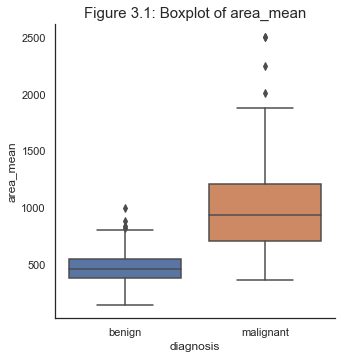

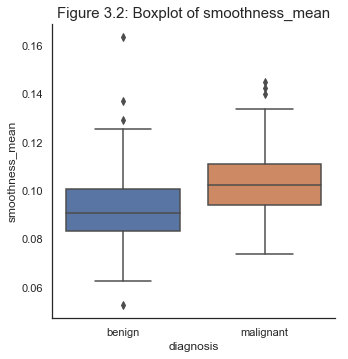

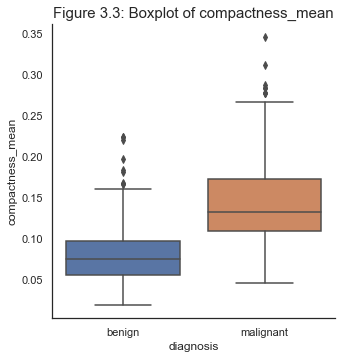

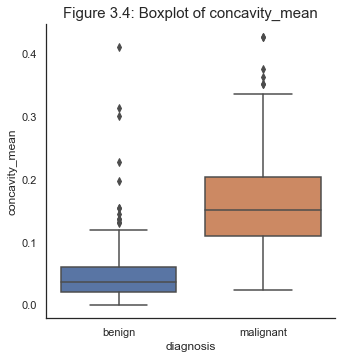

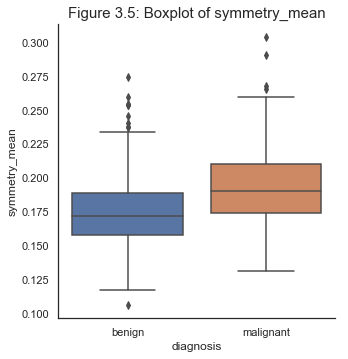

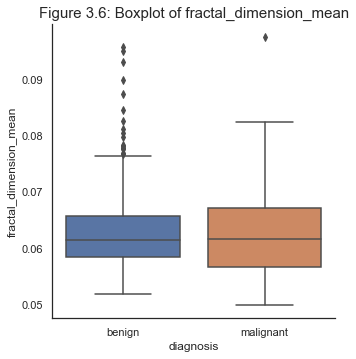

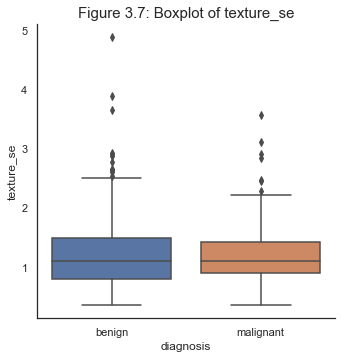

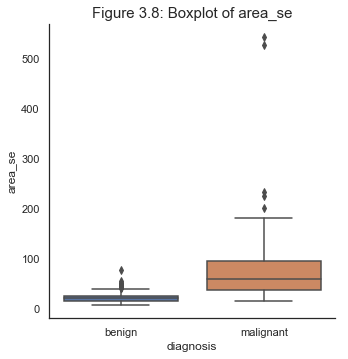

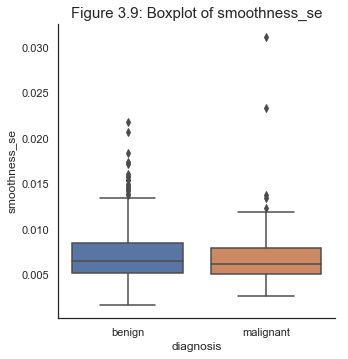

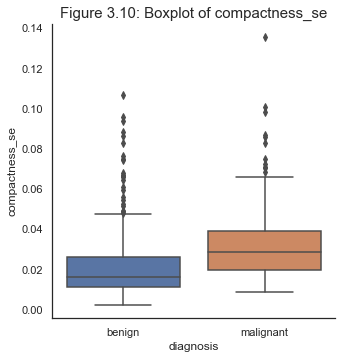

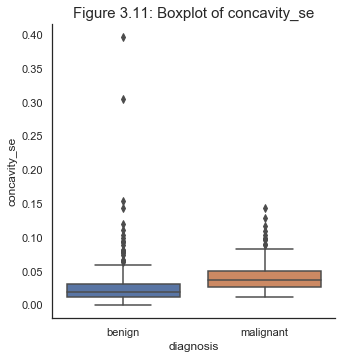

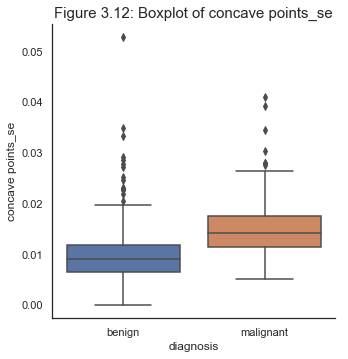

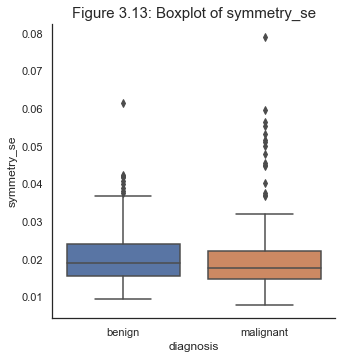

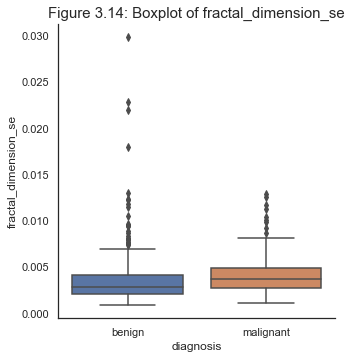

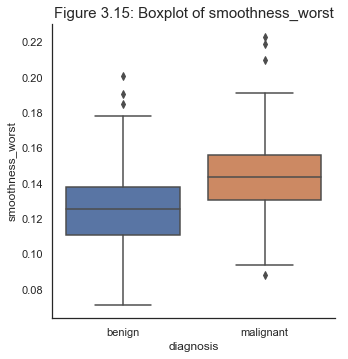

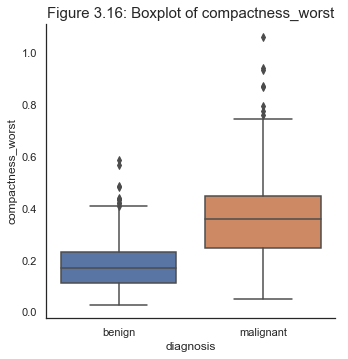

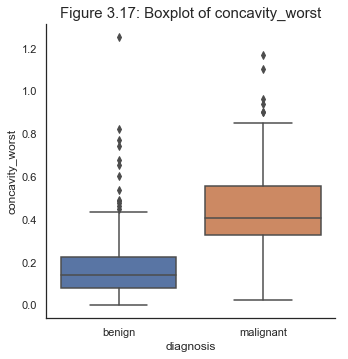

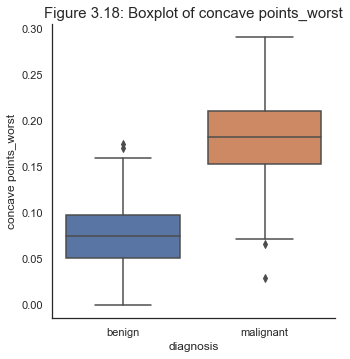

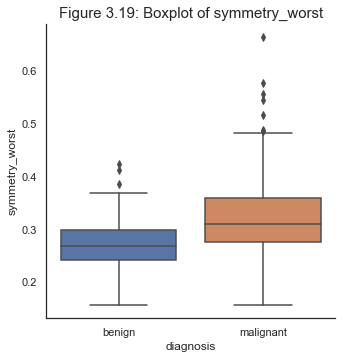

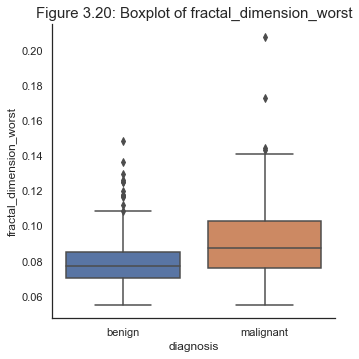

In [394]:
figure_count = 1
for feature in features[1:]:
    g = sns.catplot(x="diagnosis", y=feature, data=bc_data_no_corr, kind="box", height=5, aspect=1, legend = True).set_xticklabels(["benign", "malignant"])
    ax = plt.gca()
    ax.set_title("Figure 3."+str(figure_count) + ": Boxplot of " + feature, fontsize = 15)
    figure_count += 1

#### **g. Standardizing Data** <a name="Standardizing"></a>

> Given the range found in the variables, to avoid giving a greater weight to variables with a larger range, I standardize the data. This will also be critical for dimension reduction in later steps.

In [395]:
from sklearn.preprocessing import StandardScaler

# extract features & targets from original dataframe 
feature_data = bc_data_no_corr[features[1:]]
target_data = bc_data_no_corr[['diagnosis']]

# sanity check
feature_data.head(5)

,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1001.0,0.11840,0.27760,0.3001,0.2419,0.07871,0.9053,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1326.0,0.08474,0.07864,0.0869,0.1812,0.05667,0.7339,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1203.0,0.10960,0.15990,0.1974,0.2069,0.05999,0.7869,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,386.1,0.14250,0.28390,0.2414,0.2597,0.09744,1.1560,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1297.0,0.10030,0.13280,0.1980,0.1809,0.05883,0.7813,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [396]:
# sanity check
target_data.head(5)

,diagnosis
0,1
1,1
2,1
3,1
4,1


In [397]:
# sanity check, are there both 1s and 0s?
target_data['diagnosis'].unique()

array([1, 0])

In [399]:
# standardize the features
processed_feature_data = pd.DataFrame(StandardScaler().fit_transform(feature_data), columns=features[1:])
# sanity check
processed_feature_data.head(5)

,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.984375,1.568466,3.283515,2.652874,2.217515,2.255747,-0.565265,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.908708,-0.826962,-0.487072,-0.023846,0.001392,-0.868652,-0.876244,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.558884,0.942210,1.052926,1.363478,0.939685,-0.398008,-0.780083,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.764464,3.283553,3.402909,1.915897,2.867383,4.910919,-0.110409,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.826229,0.280372,0.539340,1.371011,-0.009560,-0.562450,-0.790244,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [400]:
processed_feature_data.describe()

,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-1.900452e-16,1.490704e-16,2.544342e-16,-1.338511e-16,2.081912e-16,5.408679e-16,-9.912009e-17,-1.088760e-16,4.426014e-16,1.958988e-16,1.678017e-16,2.185325e-17,1.523874e-16,-5.658430e-17,-2.189227e-16,-2.579464e-16,1.143393e-16,2.829215e-16,1.670212e-16,2.321908e-16
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-2.744117e+00,-1.819865e+00,-1.554264e+00,-7.378291e-01,-1.776065e+00,-1.298098e+00,-1.057501e+00,-1.913447e+00,-1.532890e+00,-1.096968e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.032397e-01,-7.226392e-01,-6.948092e-01,-4.947542e-01,-6.240183e-01,-6.929263e-01,-5.571612e-01,-6.744900e-01,-6.516807e-01,-5.851185e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-7.162650e-02,-1.782793e-01,-1.974976e-01,-3.477828e-01,-2.203352e-01,-2.810204e-01,-1.990654e-01,-1.404958e-01,-2.194304e-01,-2.299405e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,5.307792e-01,4.709834e-01,4.665523e-01,1.067726e-01,3.683553e-01,3.896541e-01,3.367521e-01,4.726567e-01,3.556925e-01,2.886421e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,4.484751e+00,4.910919e+00,6.655279e+00,1.104184e+01,8.029999e+00,6.143482e+00,1.207268e+01,6.649601e+00,7.071917e+00,9.851593e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


#### **h. Data Exploration Summary:** <a name="Summary"></a>

> Data exploration 

> preliminary visualizations, correlations, examining benign versus malignant masses, checking distributions and outliers, standardizing the data. Prepared data for predictive modeling. 

## IV. Predictive Modeling <a name="Predictive"></a>

#### **a. Dimension Reduction, PCA:** <a name="Dimension"></a>

> <font color="magenta">NEED TO FINISH INTERPRETATION</font>

> In order to determine the point at which the marginal advantage of an additional component (meaning the additional amount of variance it explains) drops off, I construct a scree plot. Looking at the scree plot it seems to be around 2 or 3 components.

> Checking first for the variance accounted for by 3 components, it is clear that the third principal component does not explain enough variance in the data (<0.08%), thus it seems reasonable to keep just 2 principal components. The two components together account for 79.9% of the data. 

> Exploring what variables load on each component in order to determine

> Reducing the data from 10 dimensions to 'n' dimensions.

In [432]:
from sklearn.decomposition import PCA
import sklearn.decomposition as skd

<function matplotlib.pyplot.show(*args, **kw)>

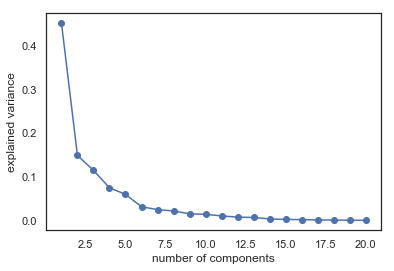

In [433]:
pca_model = skd.PCA().fit(processed_feature_data)
plt.plot(range(1,21),pca_model.explained_variance_ratio_,'b-o')
plt.xlabel('number of components') 
plt.ylabel('explained variance') 
plt.show

In [462]:
# Checking 3 components given scree plot results
pca = PCA(n_components=3)
principal_components = pca.fit_transform(processed_feature_data)
pca.explained_variance_ratio_

array([0.4516181 , 0.14891816, 0.11494921])

In [464]:
# Making dataframe and sanity check
principal_df = pd.DataFrame(data = principal_components, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
principal_df.head(5)

,Dimension 1,Dimension 2,Dimension 3
0,7.847118,-1.325340,-1.286053
1,-0.471740,-2.364225,0.797734
2,3.583566,-2.078045,0.484189
3,11.385180,3.317549,-5.483289
4,1.652299,-1.175276,2.093737


In [480]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = processed_feature_data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Plotting horizontal lines at feature weights threshold 
    ax.axhline(y=0.3, color='r', linestyle='-')
    ax.axhline(y=-0.3, color='r', linestyle='-')

    # Placing legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.20, ax.get_ylim()[1] + 0.01, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

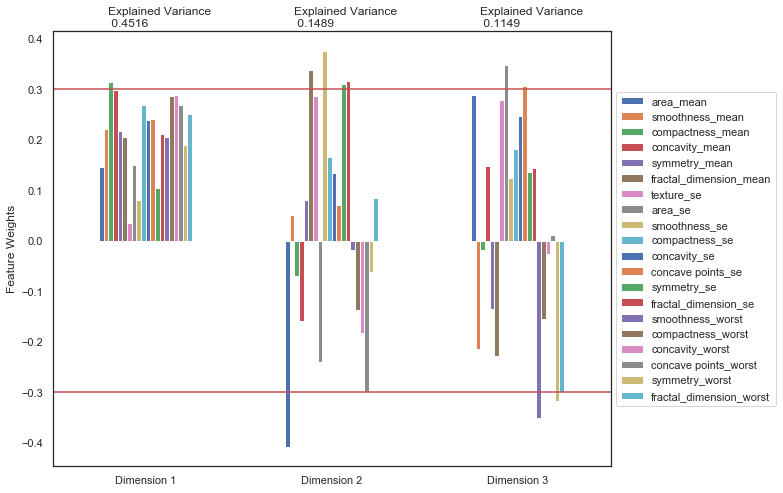

In [481]:
pca_results = pca_results(processed_feature_data, pca)

In [455]:
reduced_data.head(5)

,Dimension 1,Dimension 2,Dimension 3
0,7.847118,-1.325340,-1.286051
1,-0.471740,-2.364225,0.797732
2,3.583566,-2.078045,0.484189
3,11.385180,3.317549,-5.483288
4,1.652299,-1.175276,2.093736


In [456]:
final_df = pd.concat([reduced_data, bc_data[['diagnosis']]], axis = 1)
final_df.head(5)

,Dimension 1,Dimension 2,Dimension 3,diagnosis
0,7.847118,-1.325340,-1.286051,1
1,-0.471740,-2.364225,0.797732,1
2,3.583566,-2.078045,0.484189,1
3,11.385180,3.317549,-5.483288,1
4,1.652299,-1.175276,2.093736,1


In [457]:
# ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
final_df['Diagnosis'] = final_df['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

In [459]:
# sns.scatterplot(x='Dimension 1', y='Dimension 2', hue="Diagnosis", data=final_df, hue_order = ["Benign", "Malignant"])

Overall, we can say that approximately 75% of the information in this dataset can be explained by 'p1' and 'p2'. Now, 80% is ok, but let's see if there is a better explanation of the data with fewer features. Looking at the distribution plots from before, I remove the features that had significant overlap with each other in the malignant and benign samples and apply PCA again. Here are the features I remove:
- smoothness
- compactness
- symmetry
- fractal 

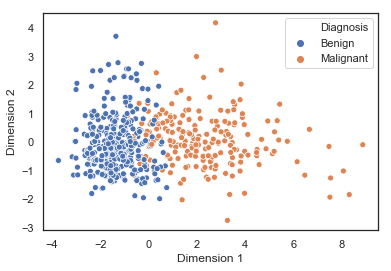

In [482]:
from sklearn.preprocessing import StandardScaler

# extract features & targets from original dataframe 
features = [
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'concavity_mean',
    'concave points_mean'
]

feature_data = bc_data[features]
target_data = bc_data['diagnosis']

# standardize the features
processed_feature_data = pd.DataFrame(StandardScaler().fit_transform(feature_data), columns=features)

# reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(processed_feature_data)
principal_df = pd.DataFrame(data = principal_components, columns=['Dimension 1', 'Dimension 2'])

# rebuild the dataframe with principal components and diagnosis 
final_df = pd.concat([principal_df, bc_data[['diagnosis']]], axis = 1)

#ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
final_df['Diagnosis'] = final_df['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

# put data on scatterplot
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue="Diagnosis", data=final_df, hue_order = ["Benign", "Malignant"])

In [483]:
print(pca.explained_variance_ratio_)

[0.75614398 0.14358948]


In [161]:
feature_loadings = pd.DataFrame(pca.components_,columns=processed_feature_data.columns,index = ['Dimension 1','Dimension 2'])

In [162]:
feature_loadings

,radius_mean,texture_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean
Dimension 1,0.449871,0.194783,0.456228,0.449491,0.396519,0.438477
Dimension 2,-0.089836,0.980192,-0.089144,-0.092402,-0.050563,-0.110054


In [163]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[ 0.95906546, -0.08345786],
       [ 0.41525013,  0.9106049 ],
       [ 0.97261614, -0.08281558],
       [ 0.95825384, -0.08584225],
       [ 0.84532606, -0.04697382],
       [ 0.93477448, -0.10224136]])

By removing the features that had similar characteristics regardless of diagnosis (smoothness, compactness, symmetry, and fractal), and then creating components based on the remaining feature, it is now possible to explain 90% of the information through dimension 1 and dimension 2, which means that these features primarily determine whether a sample is malignant or benign:

- texture (standard deviation of gray-scale values) 
- area 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour)

Therefore, when building a logistic model to predict whether a given sample is malignant or benign, these would be the criteria the model should evaluate.

#### **a. Logistic Regression:** <a name="Logistic"></a>

> Interpretation: